In [1]:
# attemp on HW1_2_1

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader

import pdb

In [3]:
device = torch.device("cuda:0")

In [4]:
data = np.load('distribution.npy')

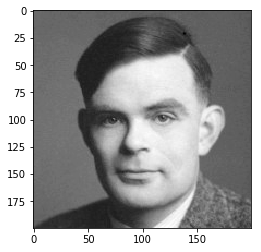

In [5]:
plt.imshow(data, cmap='gray')

In [6]:
# check that it's a probability distribution (the overall data sums to one)
np.sum(data)

1.0

How to sample from it?
From https://github.com/ikrets/CS294-158-homeworks/blob/master/HW1_2_1.ipynb, it's possible to sample $N$ samples in a given range $[0...M-1]$ from a given 1D distribution

In [7]:
# samples 100000 samples between 0 and 200*200-1 from the given distribution p
samples = np.random.choice(200 * 200, p=data.reshape(-1), size=100000)

# convert each sample to 2D:
x = samples // 200
y = samples % 200
samples = np.stack([x, y], axis=1)

In [8]:
train, valid = samples[:np.int32(0.8 * len(samples))], samples[np.int32(0.8 * len(samples)):]
print('train.shape = ', train.shape)
print('valid.shape = ', valid.shape)

train.shape =  (80000, 2)
valid.shape =  (20000, 2)


In [9]:
# calculate histogram
def hist2d(data, width, height):
    
    # init histogram
    hist = np.zeros((height, width), dtype=np.int32)
    
    # compute histogram
    for i in range(len(data)):
        hist[data[i, 0], data[i, 1]] += 1
        
    return hist

In [10]:
def one_hot(x, class_count):
    return torch.eye(class_count)[x,:]

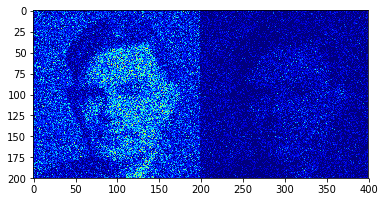

In [11]:
#visualize this
train_valid = np.concatenate((hist2d(train, 200, 200), hist2d(valid, 200, 200)), axis=1)

# plot train + valid image
plt.imshow(train_valid, cmap='jet')

Ok, the problem here is that a pixel is a joint distribution $p(x_2, x_1)$. Using bayes rule we can split this distribution as: $p(x_2, x_1) = p(x_2|x_1) p(x_1)$. 

So, We have two distributions: $p(x_1)$ and $p(x_2 | x_1)$ where $p(x_2, x_1) = p(x_2|x_1) p(x_1)$. 

The probability $p(x_1) == p_\theta(x_1)$ - which is the probability of observing $x_1$ - can be calculated using softmax formula:  $\exp(\theta) / \sum_i(exp(\theta_i))$.
Actually, $p_\theta(x_1)$ is the probability of observing $x_1$ parametrized by $\theta$
$$
p_\theta(x_1) = \frac{\exp(\theta)}{\sum_i exp(\theta_i)}
$$

How to calculate $p(x_2 | x_1)$ - the probability of observing $x_2$ given $x_1$?
In fact we can parametrize $p(x_2 | x_1)$ by $\theta$ such that $p(x_2 | x_1) == p_\theta(x_2 | x_1)$

$p_\theta(x_2 | x_1)$ can be computed by a dense network parametrized by $\theta$ that takes as input the training data $x_1$ and produces $p_\theta(x_2 | x_1)$

So, finally, we need to find $\theta$ such that $p_\theta(x_2, x_1) = p_\theta(x_2|x_1)p_\theta(x_1)$ is maximized - this is the same as maximizing the log likelihood $\hat{\theta} = argmax_\theta p_\theta(x_2|x_1)p_\theta(x_1)$-  or equivalently
minimize the log likelihood:
$$
\hat{\theta} = argmin_{\theta}(-\log(p_\theta(x_2|x_1)p_\theta(x_1)))
$$

Be aware that $x_2$ must depends on $x_1$ only and must not depend on $x_2$.

In [12]:
# The network bellow calculate p(x2 | x1)
# learning rate
class Nade(nn.Module):
    def __init__(self, n_samples):
        super(Nade, self).__init__()
        self.fc1  = nn.Linear(in_features=n_samples, out_features=n_samples, bias=True)
        self.fc2  = nn.Linear(in_features=n_samples, out_features=n_samples, bias=True)
        self.fc3  = nn.Linear(in_features=n_samples, out_features=n_samples, bias=True)
        self.drop = nn.Dropout(p=0.8)

    def forward(self, x):
        x = self.fc1(x)        
        x = F.relu(x)    
        x = self.drop(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return F.log_softmax(x)

In [14]:
# data loaders
BATCH_SIZE = 10
NUM_EPOCHS = 10
SAMPLE_SIZE = 200
learning_rate = 1.0e-4
train_loader = DataLoader(dataset=train, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset=valid, batch_size=BATCH_SIZE, shuffle=False)

model = Nade(SAMPLE_SIZE).to(device)

# training loop
1. grab a batch
2. forward:
   calculate p(x1): p_x1 = torch.exp(thetas) / torch.sum(torch.exp(thetas))
   calculate p(x2 | x1): nade(x1)
3. calculate the loss: 
   calculate loss = sum(-ln(p(x2 | x1) * p(x1)) / n_samples
4. zero gradients
5. backward: loss.backward()
6. update gradients ~ accumulate (no grads)
7. goto 1.

In [21]:
# init thetas + train_loss vector
def train_validate(model, thetas, train_loader, valid_loader, num_epochs, sample_size, device):        
    
    optimizer = torch.optim.Adam([thetas] + list(model.parameters()), lr=0.005)
                        
    train_loss = []
    
    valid_loss = []
    
    for epoch in range(num_epochs):
      
        for idx, batch in enumerate(train_loader):
                      
            # TRAINING            
            x1, x2 = batch[:,0], batch[:,1]
            
            # forward pass
            p_x1 = torch.exp(thetas) / torch.sum(torch.exp(thetas))                        
            log_p_x2_x1 = model(one_hot(x1, sample_size).to(device))
            
            # calculate losses
            loss1 = -torch.mean(torch.log(torch.gather(p_x1, 1, x1[...,None])))
            loss2 = -torch.mean(torch.gather(log_p_x2_x1, 1, x2[...,None].to(device)))
            
            # zero gradients
            optimizer.zero_grad()
            
            # calculate gradients
            loss1.backward()
            loss2.backward()
                        
            # update weights
            optimizer.step()
            
            # accumulate losses
            train_loss.append((loss1 + loss2).item() * np.log2(np.e))
            
#             with torch.no_grad():
                
# #                 # VALIDATION
# #                 model.eval()
                
# #                 batch  = next(iter(valid_loader))
                
# #                 x1, x2 = batch[:,0], batch[:,1]                
                
# #                 p_x1 = torch.exp(thetas) / torch.sum(torch.exp(thetas))
            
# # #                 log_p_x2_x1 = model(x1.float().to(device))
                
# #                 log_p_x2_x1 = model(one_hot(x1, sample_size).to(device))
# #                 inx2 = torch.transpose(x2[None, ...], 0, 1).to(device)
# #                 loss1 = (-torch.sum(torch.log(torch.gather(p_x1, 1, torch.transpose(x1[None, ...], 0, 1))))/(batch_size)).item()
# #                 loss2 = (-torch.sum(torch.gather(log_p_x2_x1, 1, inx2))/ ( batch_size)).item()
# # #                 loss = -(torch.sum(torch.log(torch.gather(p_x1, 1, torch.transpose(x1[None, ...], 0, 1)))) + torch.sum(torch.gather(log_p_x2_x1, 1, inx2))) / (sample_size * batch_size)
# # #                 pdb.set_trace()
# #                 loss = loss1 + loss2
        
# #                 valid_loss.append(loss * np.log2(np.e))

#                 # UPDATE PARAMS
#                 for param in model.parameters():
#                     param -= learning_rate * param.grad

#                 # update thetas
#                 thetas -= learning_rate * thetas.grad

#                 # zero gradients of model
#                 model.zero_grad()

#                 # zeros gradient of p(x1)
#                 thetas.grad.zero_()                
        
    return train_loss, valid_loss


In [22]:
# init parameters of p(x1)
thetas = torch.zeros((BATCH_SIZE, SAMPLE_SIZE), dtype=torch.float32, requires_grad=True)

# calculate parameters of p(x1) and p(x2 | x1)
train_loss, valid_loss = train_validate(model, thetas, train_loader, valid_loader, NUM_EPOCHS, SAMPLE_SIZE, device)

/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Text(0, 0.5, 'loss')

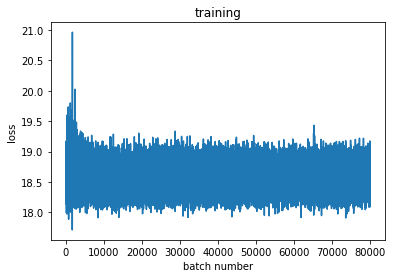

In [23]:
plt.plot(np.arange(len(train_loss)), np.array(train_loss), label='train')
# plt.plot(np.arange(len(valid_loss)), np.array(valid_loss) , label='valid')
plt.title('training')
plt.xlabel('batch number')
plt.ylabel('loss')

In [18]:
# TODO: compose the total probability: p(x1, x2) = p(x2 | x1) * p(x1)
# and calculate for each pair (x1, x2) the corresponding probability p(x1, x2)
for i in range(200):
    j = np.arange(i * 200, i * 200 + 200)
    
    


[200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235
 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253
 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271
 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289
 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307
 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325
 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343
 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361
 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379
 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397
 398 399]


In [14]:
np.mean(np.array(total_loss)/np.array(valid_loss))

1.0125000905651218

In [15]:
batch = np.random.choice(len(valid), size=n_samples)
x1, x2 = valid[batch][:,0], valid[batch][:,1]
pv_x1 = torch.exp(thetas) / torch.sum(torch.exp(thetas))
pv_x2 = torch.exp(nade(torch.from_numpy(x1).float().to(device)))

/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [17]:
print(pv_x1)
print(pv_x2)

tensor([0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050,
        0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050,
        0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050,
        0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050,
        0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050,
        0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050,
        0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050,
        0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050,
        0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050,
        0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050,
        0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050,
        0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050,
        0.0050, 0.0050, 0.0050, 0.0050, 